In [2]:
#Import required packages
import os
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from math import floor
from scipy.spatial import Delaunay

# Generating T Graph Instances

## Required functions for generating T Graph Instances

In [ ]:
def generatePlanarGraph(nr_points, seed=123):
    """A function for creating planar graphs using Delaunay triangulation

    Args:
        nr_points (int): Number of points required in the generated graph
        seed (int, optional): Seed for generating graph. Defaults to 123.

    Returns:
        graph (networkx.Graph): Networkx graph object with nodes, edges, and corresponding attributes
    """
    np.random.seed(seed)
    # Generate random unique points
    points = np.random.randint(0, 101, (int(nr_points*1.2), 2))
    points = np.unique(points, axis=0)
    points = points[np.random.choice(len(points), nr_points, replace=False), :]

    # Perform Delaunay triangulation
    tri = Delaunay(points)
    simplices = tri.simplices.copy()
    
    graph = nx.Graph()
    
    for i, coords in enumerate(points):
        graph.add_node(f"{i}", x=coords[0], y=coords[1]) #pos = tuple(coords))
        
    nodes = list(graph.nodes)

    nx.set_node_attributes(graph, 
                           values = dict(zip(nodes, np.random.randint( 4, 20, size = nr_points))), 
                           name = "n_customers")
    nx.set_node_attributes(graph, 
                           values = dict(zip(nodes, np.random.randint(15,400, size = nr_points))), 
                           name = "demand")
    nx.set_node_attributes(graph, 
                           values = dict(zip(nodes, np.random.randint(15,100, size = nr_points))), 
                           name = "workload")

    
    for triang in simplices:
        for idx1, idx2 in [[0,1],[1,2], [2,0]]:
            o, d = f"{triang[idx1]}", f"{triang[idx2]}"
            if (o,d) not in graph.edges and (d,o) not in graph.edges:
                graph.add_edge(o,d, 
                           distance = np.sqrt(pow(points[triang[idx1]][0] - points[triang[idx2]][0], 2) \
                                       + pow(points[triang[idx1]][1] - points[triang[idx2]][1],2))
                          )

    return graph

def draw_graph(g):
    """Plots the graph

    Args:
        g (networkx.Graph): Networkx graph object with nodes, edges, and corresponding attributes
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    pos =  dict(zip(g.nodes, zip(nx.get_node_attributes(g, 'x').values(), 
                                 nx.get_node_attributes(g, 'y').values() )))
    nx.draw(g, with_labels=True, node_size=400, 
            pos = pos, 
            node_color='lightgreen')
    plt.show()


def graph_is_connected(g):
    """Verifies whether the graph is connected or not

    Args:
        g (networkx.Graph): Networkx graph object with nodes, edges, and corresponding attributes

    Returns:
        boolean: True if connected, false otherwise
    """
    sp_dict = nx.shortest_path(g)
    for o in g.nodes:
        if o not in sp_dict:
            return False
        for d in g.nodes:
            if d not in sp_dict[o]:
                return False
    return True

## T Graph instance creation

#### Sample usage

In [ ]:
g = generatePlanarGraph(500, seed=1111)
graph_is_connectd(g)
draw_graph(g)

#### Generating plannar graphs with sizes $n=\{500,600,700\}$ and saving them for experimentation

In [ ]:
import os

# Define the directory path and file extension
directory_path = 'generatedPlanarInstancesData'
file_extension = '.graphml'

if not os.path.exists(directory_path):
    os.makedirs(directory_path, exist_ok=True)

for graph_size in [500,600,700]:
    for graph_idx in range(10):
        graph = generatePlanarGraph(graph_size, seed=graph_size * graph_idx)
        
        graph_name = f"planar{graph_size}_G{graph_idx}"        
        output_file_path = f"{directory_path}/{graph_name}{file_extension}"
        
        nx.write_graphml(graph, output_file_path)       

# Generating G Graph Instances

## Required functions for generating G Graph Instances

In [3]:
def graph_function(graph_input,positions):
    """Graph the networkx.Graph object

    Args:
        graph_input (networkx.Graph): Networkx graph object with nodes, edges, and corresponding attributes
        positions (dict): A dictionary containing coordinates of grid positions.
    """
    plt.figure(3,figsize=(12,12))
    nx.draw(graph_input, pos = positions, with_labels = True, node_size=400, node_color='lime')
    plt.show()

def graph_attributes_selection(graph_input,seeds):
    """Assign attributes to nodes and edges

    Args:
        graph_input (networkx.Graph): Networkx graph object with nodes, edges, and corresponding attributes
        seeds (int): seed
    """
    random.seed(seeds)

    demand= {}
    for v in graph_input.nodes:
        demand[v] = random.randint(15,400)

    workload= {}
    for v in graph_input.nodes:
        workload[v] = random.randint(15,100)

    n_customers= {}
    for v in graph_input.nodes:
        n_customers[v] = random.randint(4,20)

    distance= {}
    for e in graph_input.edges:
        distance[e] = random.randint(5,12)


    nx.set_node_attributes(graph_input, values = n_customers, name = "n_customers")
    nx.set_node_attributes(graph_input, values = demand, name = "demand")
    nx.set_node_attributes(graph_input, values = workload, name = "workload")
    nx.set_edge_attributes(graph_input, values = distance, name = "distance")

def create_layout(graph, N):
    """
    Creates a layout for input graph to be used as input for the BVNS and TerritoryDesignProblem classes

    Parameters:
    -----------
    graph_input : networkx.Graph
        A graph representing the road network.

    Returns:
    --------
    coords : list
        A list of tuples containing the coordinates of the nodes.
    grid_pos : dict
        A dictionary containing coordinates of grid positions.
    """
    GRID_ORIGIN = nx.grid_2d_graph(N,N)
    labels=dict(((i,j),i + (N-1-j)*N) for i, j in GRID_ORIGIN.nodes())
    # nx.relabel_nodes(DEDE,labels,False) #False=relabel the nodes in place
    inds=labels.keys()
    vals=labels.values()
    inds=[(N-j-1,N-i-1) for i,j in inds]

    #Create the dictionary of positions for the grid
    grid_pos=dict(zip(vals,inds))

    #turn the keys in grid_pos to strings
    grid_pos = {str(k):v for k,v in grid_pos.items()}

    for i in list(grid_pos):
        if i not in graph.nodes:
            grid_pos.pop(i)
    coords = []
    for i in inds:
        for key, value in grid_pos.items():
            if i == value:
                coords.append(i)

    return grid_pos,coords

def create_and_manipulate_graph(grid_size,region,seedNumber):
    """_summary_

    Args:
        grid_size (int): Size of reuired grid where the total number of nodes is grid_size X grid_size
        region (string): Type of generated G graph
        seedNumber (int): seed

    Returns:
        graph (networkx.Graph): Networkx graph object with nodes, edges, and corresponding attributes
    """

    random.seed(seedNumber)

    # Define the regions based on grid_size
    if grid_size == 27:
        regions = {
            'R1': [str(i * 27 + j) for i in range(13) for j in range(9)],
            'R2': [str(i * 27 + j) for i in range(13, 27) for j in range(9)],
            'R3': [str(i * 27 + j) for i in range(9) for j in range(9, 18)],
            'R4': [str(i * 27 + j) for i in range(9, 18) for j in range(9, 18)],
            'R5': [str(i * 27 + j) for i in range(18, 27) for j in range(9, 18)],
            'R6': [str(i * 27 + j) for i in range(13) for j in range(18, 27)],
            'R7': [str(i * 27 + j) for i in range(13, 27) for j in range(18, 27)]
        }
    elif grid_size == 33:
        regions = {
            'R1': [str(i * 33 + j) for i in range(16) for j in range(11)],
            'R2': [str(i * 33 + j) for i in range(16, 33) for j in range(11)],
            'R3': [str(i * 33 + j) for i in range(11) for j in range(11, 22)],
            'R4': [str(i * 33 + j) for i in range(11, 22) for j in range(11, 22)],
            'R5': [str(i * 33 + j) for i in range(22, 33) for j in range(11, 22)],
            'R6': [str(i * 33 + j) for i in range(16) for j in range(22, 33)],
            'R7': [str(i * 33 + j) for i in range(16, 33) for j in range(22, 33)]
        }
    elif grid_size == 30:
        regions = {
            'R1': [str(i * 30 + j) for i in range(15) for j in range(10)],
            'R2': [str(i * 30 + j) for i in range(15, 30) for j in range(10)],
            'R3': [str(i * 30 + j) for i in range(10) for j in range(10, 20)],
            'R4': [str(i * 30 + j) for i in range(10, 20) for j in range(10, 20)],
            'R5': [str(i * 30 + j) for i in range(20, 30) for j in range(10, 20)],
            'R6': [str(i * 30 + j) for i in range(15) for j in range(20, 30)],
            'R7': [str(i * 30 + j) for i in range(15, 30) for j in range(20, 30)]
        }
    else:
        raise ValueError("Invalid grid_size. Supported values are 27 and 33.")

    
    if region == "Corners":
        region_to_remove = regions['R1'] + regions['R2'] + regions['R7'] + regions['R6']
        outside_to_remove = regions['R3'] + regions['R4'] + regions['R5']
    if region == "Center":
        region_to_remove = regions['R3']+regions['R4']+regions['R5']
        outside_to_remove = regions['R1']+regions['R2']+regions['R6']+regions['R7']
    if region == "Diagonal":
        region_to_remove = regions['R1']+regions['R4']+regions['R7']
        outside_to_remove = regions['R2']+regions['R3']+regions['R5']+regions['R6']

    n = (grid_size * grid_size) - (grid_size * grid_size)/3

    connected_final = False
    
    while not connected_final:
        graph = nx.grid_2d_graph(grid_size, grid_size)
        graph = nx.relabel_nodes(graph, {(i, j): str(i * grid_size + j) for i in range(grid_size) for j in range(grid_size)})
        grid_pos,coords = create_layout(graph,grid_size)
        region_removal = floor(2 / 3 * (grid_size * grid_size - n))
        outside_removal = floor(1 / 3 * (grid_size * grid_size - n))

        def remove_region(graph, region_to_remove, region_removal):

            i = 0
            while i < region_removal:
                node_to_remove = random.choice(region_to_remove)
                G_COPY = graph.copy()
                graph.remove_node(node_to_remove)
                region_to_remove.remove(node_to_remove)
                if not nx.is_connected(graph):
                    graph = G_COPY.copy()
                    region_to_remove.append(node_to_remove)
                else:
                    i += 1
            return graph

        graph = remove_region(graph, region_to_remove, region_removal)
        graph = remove_region(graph, outside_to_remove, outside_removal)

        connected_final = nx.is_connected(graph)
    
    graph_attributes_selection(graph,seedNumber)

    return graph

## Example usage

In [ ]:
# Example usage

#Choose grid size between [27,30,33]
grid_size = 27

#Choose between 3 regions ["Center", "Corners", "Diagonal"]
region = "Center"

#Choose the seed for graph generation and attributes
seedNumber = 7

graph = create_and_manipulate_graph(grid_size,region,seedNumber)
nx.write_graphml(graph, f'newGeneratedInstances/{grid_size}x{grid_size}Graphs/{region}{int((grid_size*grid_size)-(grid_size*grid_size)/3)}_G{seedNumber}.graphml')

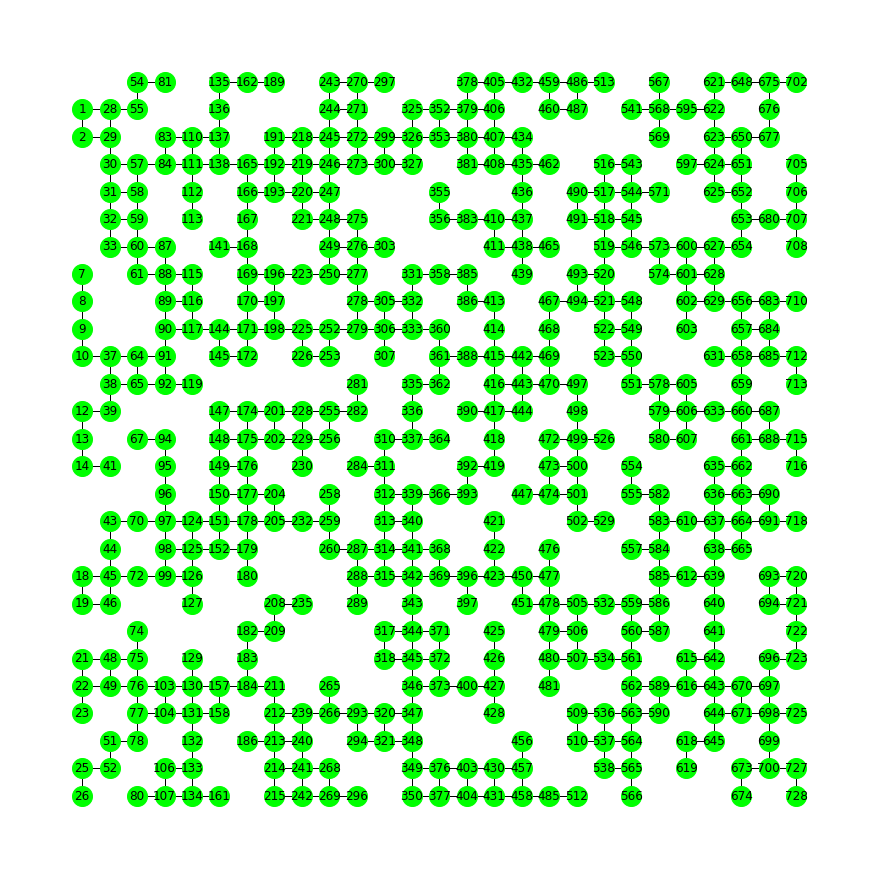

In [4]:
# Reading a graph object 

graph = nx.read_graphml('GGraphInstances/newGeneratedInstances/27x27Graphs/Corners486_G7.graphml')
# graph = create_and_manipulate_graph(27,'Center','center10')
grid_pos, coords = create_layout(graph,27)
graph_function(graph, grid_pos)

## Create Adjusted Graphs

In [ ]:
#Ensure to select the correct path for the instances you want to adjust. Below is an example

# Define the attribute ranges
attribute_ranges = {
    'demand': {'low': (15, 150), 'high': (150, 400)},
    'workload': {'low': (15, 30), 'high': (30, 100)},
    'n_customers': {'low': (4, 8), 'high': (8, 20)}
}

# Define the percentages for low attribute values
low_percentages = [0.25, 0.50, 0.90]

# Define the directory path and file extension
directory_path = 'newGeneratedInstances'
file_extension = '.graphml'

percentage_combinations = list(product(low_percentages, repeat=len(attribute_ranges)))

for combination in percentage_combinations:
    for folder_path, _, files in os.walk(directory_path):
        if 'Adjusted' not in folder_path and len(files) and '.ipynb_checkpoints' not in folder_path:
            combination_folder = f"newGeneratedInstances/Adjusted/d{combination[0]}_w{combination[1]}_c{combination[2]}/{folder_path.split('/')[1]}"
            os.makedirs(combination_folder, exist_ok=True)
            for file_name in files:
                # print(folder_path, filename)
                if file_name.endswith('.graphml') and 'checkpoint' not in file_name:
                    file_path = os.path.join(folder_path, file_name)
                    print(file_path, file_name)

                    graph = nx.read_graphml(file_path)

                    low_demand_nodes = list(random.sample(list(graph.nodes()),floor(combination[0]*len(list(graph.nodes())))))
                    low_workload_nodes = list(random.sample(list(graph.nodes()),floor(combination[1]*len(list(graph.nodes())))))
                    low_n_customers_nodes = list(random.sample(list(graph.nodes()),floor(combination[2]*len(list(graph.nodes())))))

                    for node in list(graph.nodes()):
                        attribute_values = graph.nodes[node]
                        new_attribute_values = {}
                        if node in low_demand_nodes:
                            new_attribute_values['demand'] = random.randint(*attribute_ranges['demand']['low'])
                        else:
                            new_attribute_values['demand'] = random.randint(*attribute_ranges['demand']['high'])

                        if node in low_workload_nodes:
                            new_attribute_values['workload'] = random.randint(*attribute_ranges['workload']['low'])
                        else:
                            new_attribute_values['workload'] = random.randint(*attribute_ranges['workload']['high'])

                        if node in low_n_customers_nodes:
                            new_attribute_values['n_customers'] = random.randint(*attribute_ranges['n_customers']['low'])
                        else:
                            new_attribute_values['n_customers'] = random.randint(*attribute_ranges['n_customers']['high'])

                        attribute_values.update(new_attribute_values)

                    output_file_path = f"{combination_folder}/{file_name}"
                    print(output_file_path)
                    nx.write_graphml(graph, output_file_path)